# Factoring and Shor's Algorithm

Quantum computers can factor large composite numbers in polynomial time using an algorithm initially introduced in [S1994] and improved over the years. Notably, [GE2019] optimized and compiled a variant of Shor's algorithm for the surface code. We'll first investigate how modular exponentiation can be used to back out factors of composite numbers then show the reference decomposition for modular exponentiation.


### References:

 - [S1994] Algorithms for quantum computation: discrete logarithms and factoring.
[10.1109/SFCS.1994.365700](https://dx.doi.org/10.1109/SFCS.1994.365700). Shor. 1994.

 - [GE2019] How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits.
[arxiv:1905.09749](https://arxiv.org/abs/1905.09749). Gidney and Ekerå. 2019.

## Walk through the factoring of 13 * 17

We can factor a large number by finding the period of modular exponentiation. We set our input variables with demo values that we can manage classically.

 - `N` is the composite number to factor. Here, we set it to $13*17$
 - `n` is its bitsize

In [1]:
import numpy as np
N = 13*17
n = int(np.ceil(np.log2(N)))
N, n

(221, 8)

Our modular exponentiation uses the composite number as the modulus and we will try a variety of different exponent values (to find the period). The base of the exponent doesn't matter that much and we choose a random base $g$.

In [2]:
g = 8
g

8

### Period Finding

We need to find the period of the exponentiation -- namely how long it takes to cycle back to 1 under modular arithmetic. Below, we do this with a classical `for` loop for demonstration. On the quantum computer, we will execute modular exponentiation using a superposition of exponent values.

In [3]:
for e in range(20):
    f = (g ** e) % N
    
    star = ' *' if f == 1 else ''
    print(f'{e:5d} {f:5d}{star}')

    0     1 *
    1     8
    2    64
    3    70
    4   118
    5    60
    6    38
    7    83
    8     1 *
    9     8
   10    64
   11    70
   12   118
   13    60
   14    38
   15    83
   16     1 *
   17     8
   18    64
   19    70


The period is indeed a consistent value of 8.

In [4]:
16-8, 8-0

(8, 8)

In [5]:
period = 8

### Use the period to find factors

We can use some numerical tricks find our two factors from this period. Consult the references if you'd like an explanation for why this works. Note that we make some assertions about $g$ and the period. If these are violated, you must re-run the period finding with a different choice for $g$.

In [6]:
assert period % 2 == 0
assert g**(period//2) != -1

half_period = g**(period//2)
p1 = half_period + 1
m1 = half_period - 1

assert (p1*m1) % N == 0

In [7]:
print(f'gcd{p1%N, N}, gcd{m1%N, N}')
import math
math.gcd(p1%N, N), math.gcd(m1%N, N)

gcd(119, 221), gcd(117, 221)


(17, 13)

We've recovered the two numbers and the factoring has been successfull.

## Using the `ModExp` Bloq

We can use the classical simulation capabilities of the library to show that our `ModExp` bloq performs the same arithmetic. We can test that its decomposition into sub-bloqs is correct by classically simulating the decomposition. When executed on a quantum computer, the `exponent` register will be in superposition leading to exponentially faster period finding.

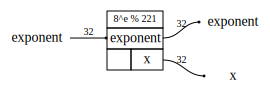

In [8]:
from qualtran.bloqs.factoring.mod_exp import ModExp
from qualtran.drawing import show_bloq

mod_exp = ModExp(base=g, mod=N, exp_bitsize=32, x_bitsize=32)
show_bloq(mod_exp)

In [9]:
mod_exp_decomp = mod_exp.decompose_bloq()
mod_exp_decomp.bloq_counts()

{CtrlModMul(k=1, mod=221, bitsize=32): 29,
 Split(dtype=QUInt(bitsize=32)): 1,
 CtrlModMul(k=8, mod=221, bitsize=32): 1,
 CtrlModMul(k=118, mod=221, bitsize=32): 1,
 Join(dtype=QAny(bitsize=32)): 1,
 CtrlModMul(k=64, mod=221, bitsize=32): 1,
 IntState(val=1, bitsize=32): 1}

In [10]:
for e in range(20):
    ref = (g ** e) % N
    _, bloq_eval = mod_exp.call_classically(exponent=e)
    _, decomp_eval = mod_exp_decomp.call_classically(exponent=e)
    
    star = ' *' if ref == 1 else ''
    print(f'{e:5d} {ref:5d} {bloq_eval:5d} {decomp_eval:5d} {star}')

    0     1     1     1  *
    1     8     8     8 
    2    64    64    64 
    3    70    70    70 
    4   118   118   118 
    5    60    60    60 
    6    38    38    38 
    7    83    83    83 
    8     1     1     1  *
    9     8     8     8 
   10    64    64    64 
   11    70    70    70 
   12   118   118   118 
   13    60    60    60 
   14    38    38    38 
   15    83    83    83 
   16     1     1     1  *
   17     8     8     8 
   18    64    64    64 
   19    70    70    70 
